# Construisez un modèle de scoring

## Problématique métier

L'objectif est de construire et comparer les performances de plusieurs modèles de scoring déterminants la capacité d'un emprunteur à rembourser un prêt. Ces modèles doivent être facilement interprétables car ils s'adressent à notre client, une société financière nommée "Prêt à dépenser". Une mesure de l'importance des variables sera réalisée pour que le client puisse analyser a posteriori la contribution des différentes variables retenues.

## Description du jeu de données

**Le jeu de données provient de Home Credit, une société financière fournissant des prêts à des personnes qui disposent de peu d'historique. Les données sont partitionnées dans les fichiers suivants:**

* application_{train|test}.csv:

  Il s'agit des tables principales: une ligne correspond à un prêt. Les données sont séparées en jeux d'entraînement et de test.


* bureau.csv

  Historique disponible des anciens prêts accordés aux individus de notre échantillon.
  Chaque ligne correspond à un ancien prêts.


* bureau_balance.csv

  Il s'agit de l'historique individuel mensuel de chaque emprunt présent dans bureau.csv.
  Chaque ligne correspond à un mois d'historique d'un emprunt.


* POS_CASH_balance.csv

  Historique du solde mensuel des emprunteurs de notre échantillon.
  Chaque ligne correspond à un mois d'historique d'un prêt.
  

* credit_card_balance.csv

  Historique du solde mensuel des cartes de crédit des clients de Home Credit présents dans notre échantillon.
  Chaque ligne correspond à un mois d'historique d'un compte.


* previous_application.csv

  Historique des demandes d'emprunt (acceptées ou non).
  Une ligne correspond à une demande.


* installments_payments.csv

  Historique des versements des crédit précedemment attribués.
  Une ligne correspond à un versement.


* HomeCredit_columns_description.csv

  Description de chaque colonne de chaque fichier.

<br>


**Ce diagramme présente les relations entre les données:**

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [1]:
import os
import numpy as np
import pandas as pd
import gc
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# debug
debug = True

In [2]:
# '../input/home-credit-default-risk/application_train.csv'
if not debug:
    num_rows = None
else:
    num_rows = 10000
app_train = pd.read_csv('./data/application_train.csv', nrows= num_rows)
print(f"Le jeu d'entrainement comporte {app_train.shape[0]} lignes et {app_train.shape[1]} colonnes.", )
app_train.head()

Le jeu d'entrainement comporte 10000 lignes et 122 colonnes.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
app_test = pd.read_csv('./data/application_test.csv', nrows= num_rows)
print(f"Le jeu de test comporte {app_test.shape[0]} lignes et {app_test.shape[1]} colonnes.", )
app_test.head()

Le jeu de test comporte 10000 lignes et 121 colonnes.


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Transformation du jeu de données

L'objectif est de réaliser une analyse exploratoire des données pour les nettoyer, et réaliser un feature engineering.

### Traitement des variables catégorielles

L'objectif est d'encoder les variables catégorielles pour pouvoir les utiliser avec nos modèles de machine learning. Comme la plupart des variables ont un faible nombre de catégories uniques, nous allons utiliser le one-hot encoding sur les variables en possédant plus de deux, et le label encoding sur les autres.

In [4]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               5
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [5]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print(f'Le label encoding a été utilisé sur {le_count} colonnes.')

Le label encoding a été utilisé sur 4 colonnes.


In [6]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print(f"Le jeu de test comporte désormais {app_test.shape[0]} lignes et {app_test.shape[1]} colonnes.", )
print(f"Le jeu d'entrainement comporte désormais {app_train.shape[0]} lignes et {app_train.shape[1]} colonnes.", )

Le jeu de test comporte désormais 10000 lignes et 237 colonnes.
Le jeu d'entrainement comporte désormais 10000 lignes et 237 colonnes.


Le One-Hot encoding a créé plus de variables dans la table d'entrainement que dans celle de test. Les modèles de Machine Learning nécéssitent que les deux jeux possèdent les mêmes features. Il faut donc aligner les deux jeux de données.

In [7]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print(f"Le jeu de test comporte désormais {app_test.shape[0]} lignes et {app_test.shape[1]} colonnes.", )
print(f"Le jeu d'entrainement comporte désormais {app_train.shape[0]} lignes et {app_train.shape[1]} colonnes.", )

Le jeu de test comporte désormais 10000 lignes et 235 colonnes.
Le jeu d'entrainement comporte désormais 10000 lignes et 236 colonnes.


### Choix des variables

On utilise les n features les plus corrélées à la target.

In [8]:
n_features = 25
features_names, correlation_with_target = zip(*sorted(list(dict(app_train[app_train.columns[1:]].corr()['TARGET'][:]).items()), key=lambda item: -abs(item[1])))
features_names = list(features_names[1:n_features+1])
correlation_with_target = list(correlation_with_target[1:n_features+1])

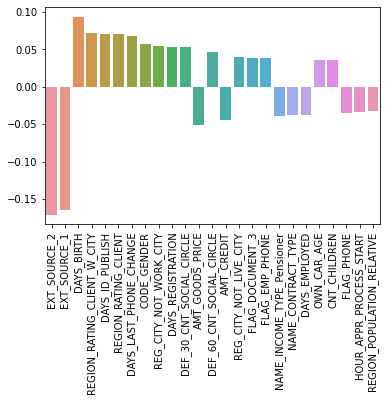

In [9]:
ax = sns.barplot(x=features_names, y=correlation_with_target)
for item in ax.get_xticklabels():
        item.set_rotation(90)

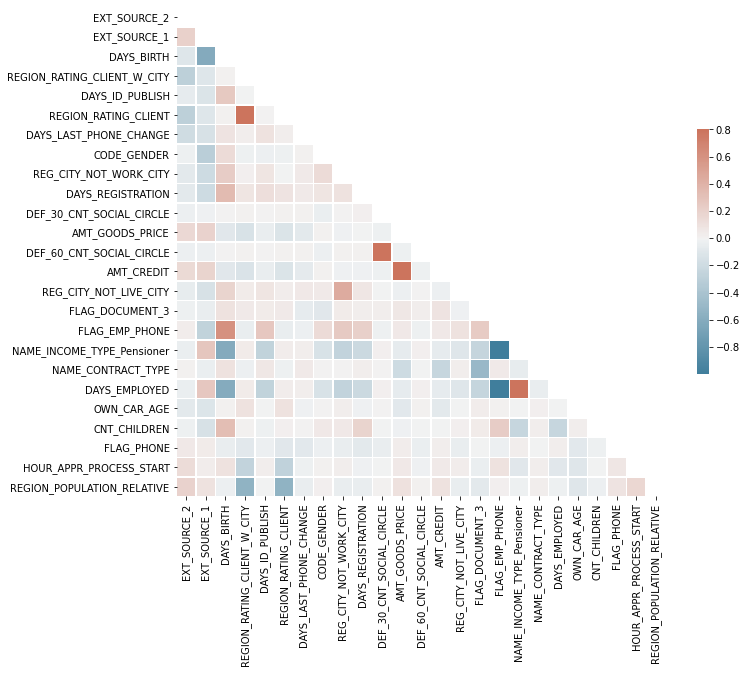

In [10]:
# affichage de la matrice de corrélation
short_df = pd.DataFrame(data=app_train, columns=features_names)
corr = short_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Valeurs manquantes

In [11]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
missing_values_t = missing_values_table(short_df)
missing_values_t.head(20)

Your selected dataframe has 25 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
OWN_CAR_AGE,6662,66.6
EXT_SOURCE_1,5647,56.5
DEF_30_CNT_SOCIAL_CIRCLE,42,0.4
DEF_60_CNT_SOCIAL_CIRCLE,42,0.4
EXT_SOURCE_2,26,0.3
AMT_GOODS_PRICE,7,0.1


### Traitement des valeurs aberrantes

In [12]:
for feat in features_names:
    if 'DAYS' in feat: # changing days to years
        print((app_train[feat] / -365).describe(), '\n')
    else:
        print(app_train[feat].describe(), '\n')

count    9974.000000
mean        0.515509
std         0.189522
min         0.000074
25%         0.393858
50%         0.565894
75%         0.664474
max         0.855000
Name: EXT_SOURCE_2, dtype: float64 

count    4353.000000
mean        0.504268
std         0.209818
min         0.024417
25%         0.332779
50%         0.511269
75%         0.673915
max         0.929394
Name: EXT_SOURCE_1, dtype: float64 

count    10000.000000
mean        43.904858
std         11.891860
min         21.109589
25%         33.941781
50%         43.242466
75%         53.685616
max         68.931507
Name: DAYS_BIRTH, dtype: float64 

count    10000.000000
mean         2.026600
std          0.504894
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64 

count    10000.000000
mean         8.173646
std          4.143865
min         -0.000000
25%          4.676712
50%          8.841096
75%         11.7726

Text(0.5, 0, 'Days Employment')

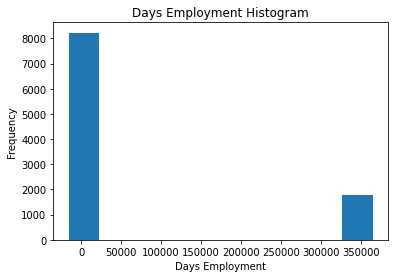

In [13]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

Text(0.5, 0, 'Days Employment')

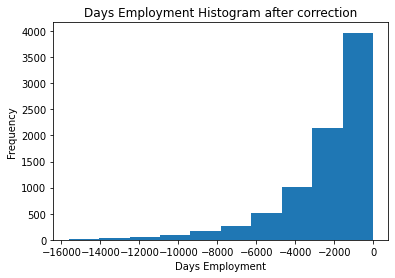

In [14]:
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram after correction')
plt.xlabel('Days Employment')

### Nouvelles variables

Enfants à charge

In [15]:
print(app_train['CNT_CHILDREN'].describe(), '\n')
print(app_train['CNT_FAM_MEMBERS'].describe(), '\n')

count    10000.000000
mean         0.416300
std          0.722251
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          7.000000
Name: CNT_CHILDREN, dtype: float64 

count    10000.000000
mean         2.156400
std          0.906102
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: CNT_FAM_MEMBERS, dtype: float64 



In [16]:
extended_app_train = app_train.copy()
extended_app_test = app_test.copy()
custom_features = ['EFFECTIVE_INCOME', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']
extended_app_train['EFFECTIVE_INCOME'] = extended_app_train['AMT_INCOME_TOTAL'] - extended_app_train['AMT_INCOME_TOTAL'] * extended_app_train['CNT_CHILDREN'] / extended_app_train['CNT_FAM_MEMBERS']
extended_app_test['EFFECTIVE_INCOME'] = extended_app_test['AMT_INCOME_TOTAL'] - extended_app_test['AMT_INCOME_TOTAL'] * extended_app_test['CNT_CHILDREN'] / extended_app_test['CNT_FAM_MEMBERS']
extended_app_train['CREDIT_INCOME_PERCENT'] = extended_app_train['AMT_CREDIT'] / extended_app_train['AMT_INCOME_TOTAL']
extended_app_test['CREDIT_INCOME_PERCENT'] = extended_app_test['AMT_CREDIT'] / extended_app_test['AMT_INCOME_TOTAL']
extended_app_train['ANNUITY_INCOME_PERCENT'] = extended_app_train['AMT_ANNUITY'] / extended_app_train['AMT_INCOME_TOTAL']
extended_app_test['ANNUITY_INCOME_PERCENT'] = extended_app_test['AMT_ANNUITY'] / extended_app_test['AMT_INCOME_TOTAL']
extended_app_train['CREDIT_TERM'] = extended_app_train['AMT_ANNUITY'] / extended_app_train['AMT_CREDIT']
extended_app_test['CREDIT_TERM'] = extended_app_test['AMT_ANNUITY'] / extended_app_test['AMT_CREDIT']
extended_app_train['DAYS_EMPLOYED_PERCENT'] = extended_app_train['DAYS_EMPLOYED'] / extended_app_train['DAYS_BIRTH']
extended_app_test['DAYS_EMPLOYED_PERCENT'] = extended_app_test['DAYS_EMPLOYED'] / extended_app_test['DAYS_BIRTH']

## Comparaison des modèles et synthèse

### Métriques

In [17]:
previous_results = {}

def roc_auc(model, predictor, xtest, ytest, lprob=None):
    ns_probs = [0 for _ in range(len(ytest))]
    if lprob is None:
        lr_probs = predictor.predict_proba(xtest)[:, 1]
    else:
        lr_probs = lprob
    # calculate scores
    ns_auc = roc_auc_score(ytest, ns_probs)
    lr_auc = roc_auc_score(ytest, lr_probs)
    # summarize scores
    if model in previous_results:
        print(f'{model}: ROC AUC={round(lr_auc, 3)} (précédemment {round(previous_results[model], 3)})')
    else:
        print(f'{model}: ROC AUC=%.3f' % (lr_auc))
    previous_results[model] = lr_auc
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Hasard')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model)
    # axis labels
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Séparation du jeu de données et balance de la variable cible

In [18]:
def split_data(df):
    
    # train test split
    y = df['TARGET']
    X = df[features_names].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    
    # imputation
    imputer = SimpleImputer(strategy = 'median')
    scaler = MinMaxScaler(feature_range = (0, 1))

    imputer.fit(X_train)
    X_train = imputer.transform(X_train)
    X_test = imputer.transform(X_test)
    
    # noramlization
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # balance
    y_train.plot.hist(title = 'TARGET distribution')
    plt.show()
    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    y_train.plot.hist(title = 'TARGET distribution after balance')
    plt.show()
    
    return y, X, X_train, X_test, y_train, y_test

### Tuning des hyperparamètres

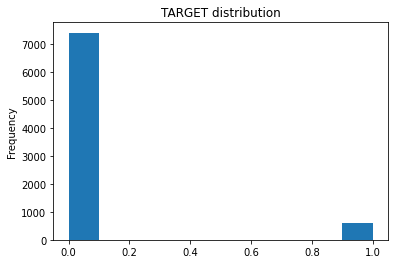

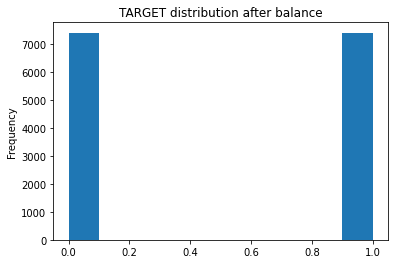

In [19]:
y, X, X_train, X_test, y_train, y_test = split_data(app_train)

In [20]:
# regression logistique
if not debug:
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]} # l1 lasso l2 ridge
    reglog=LogisticRegression()
    reglog_grid=GridSearchCV(reglog, grid, cv=10, scoring="roc_auc")
    reglog_grid.fit(X_train, y_train)
    print(reglog_grid.best_params_)
    print("accuracy :", reglog_grid.best_score_)
    reglog_params = reglog_grid.best_params_
else:
    reglog_params = {'C': 10.0, 'penalty': 'l2'}

In [21]:
# random forest
if not debug:
    rfc=RandomForestClassifier(random_state=42)
    param_grid = { 
        'n_estimators': [100, 500, 1000],
        'max_features': ['auto', 'sqrt', 'log2']
    }
    forest_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring="roc_auc")
    forest_grid.fit(X_train, y_train)
    print(forest_grid.best_params_)
    print("accuracy :", forest_grid.best_score_)
    forest_params = forest_grid.best_params_
else:
    forest_params = {'max_features': 'log2', 'n_estimators': 700}

In [22]:
# SVM à noyau
if not debug:
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']} 
    svm_grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=0, scoring="roc_auc")
    svm_grid.fit(X_train, y_train)
    print(svm_grid.best_params_)
    print("accuracy :", svm_grid.best_score_)
    svm_params = svm_grid.best_params_
else:
    svm_params = {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

### Regression Logistique

In [23]:
def make_reg_log():
    reg_log = LogisticRegression(C=reglog_params['C'], penalty=reglog_params['penalty'])
    reg_log.fit(X_train, y_train)
    roc_auc("Regression Logistique", reg_log, X_test, y_test)

### Random Forest

In [24]:
def make_random_forest():
    random_forest = RandomForestClassifier(n_estimators=forest_params['n_estimators'], random_state=50, max_features=forest_params['max_features'], verbose=False, n_jobs=-1)
    res = random_forest.fit(X_train, y_train)
    roc_auc("Random Forest", random_forest, X_test, y_test)

### SVM à Noyau

In [25]:
def make_kernel_SVM():
    svm_classifier = svm.SVC(kernel='rbf', gamma=svm_params['gamma'], C=svm_params['C'], probability=True)
    svm_classifier.fit(X_train, y_train)
    roc_auc("SVM à Noyau", svm_classifier, X_test, y_test)

### Gradient Boosting

In [26]:
def kfold_lightgbm(num_folds=10):
    # Divide in training/validation and test data
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(X.shape[0])
    feature_importance_df = pd.DataFrame()
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
        train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
        valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=1,
            verbose=-1,
            n_jobs=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose=0, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features_names
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
    roc_auc("LGBM", None, X_test, y, oof_preds)
    
    return feature_importance_df

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()



Regression Logistique: ROC AUC=0.751


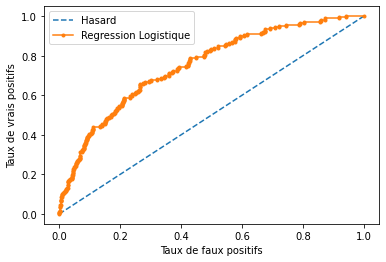

Random Forest: ROC AUC=0.697


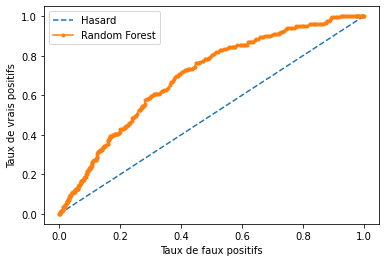

SVM à Noyau: ROC AUC=0.755


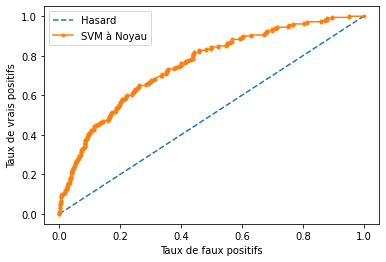

LGBM: ROC AUC=0.716


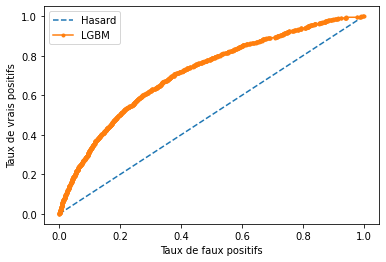

In [27]:
make_reg_log()
make_random_forest()
make_kernel_SVM()
feat_importance = kfold_lightgbm()

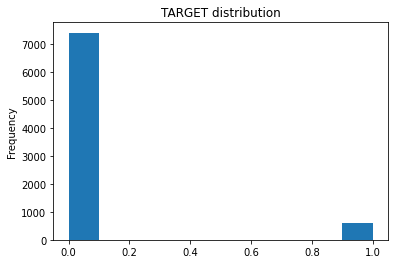

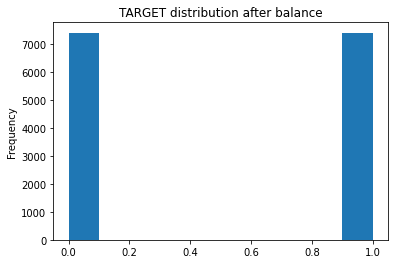

Regression Logistique: ROC AUC=0.751 (précédemment 0.751)


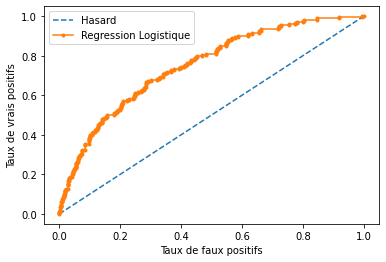

Random Forest: ROC AUC=0.709 (précédemment 0.697)


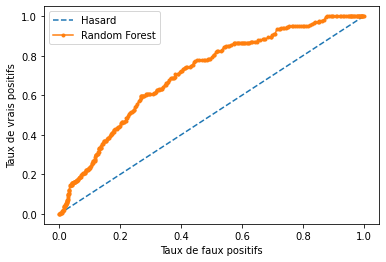

SVM à Noyau: ROC AUC=0.75 (précédemment 0.755)


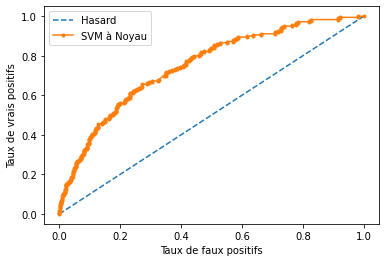

LGBM: ROC AUC=0.727 (précédemment 0.716)


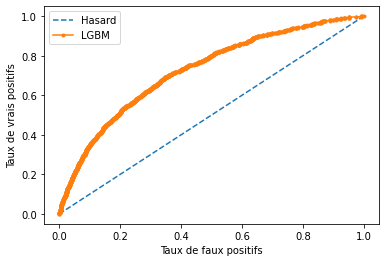

In [28]:
features_names += custom_features
y, X, X_train, X_test, y_train, y_test = split_data(extended_app_train)
make_reg_log()
make_random_forest()
make_kernel_SVM()
feat_importance_2 = kfold_lightgbm()

## Interprétabilité du modèle

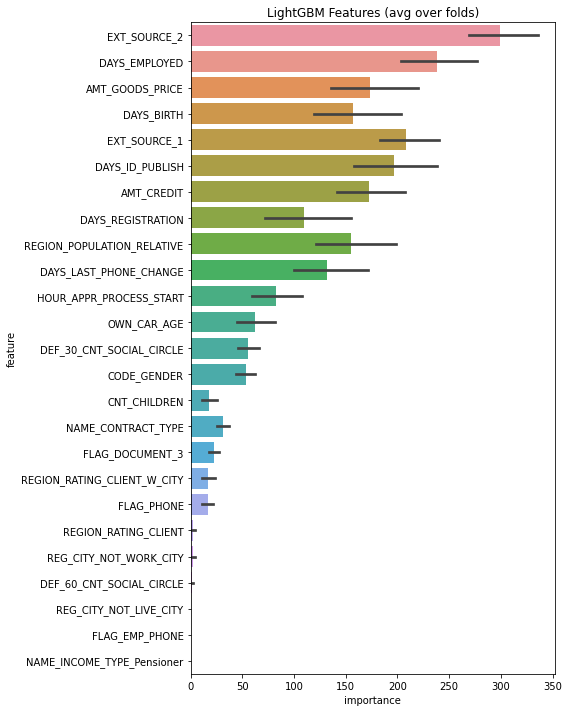

In [29]:
display_importances(feat_importance)

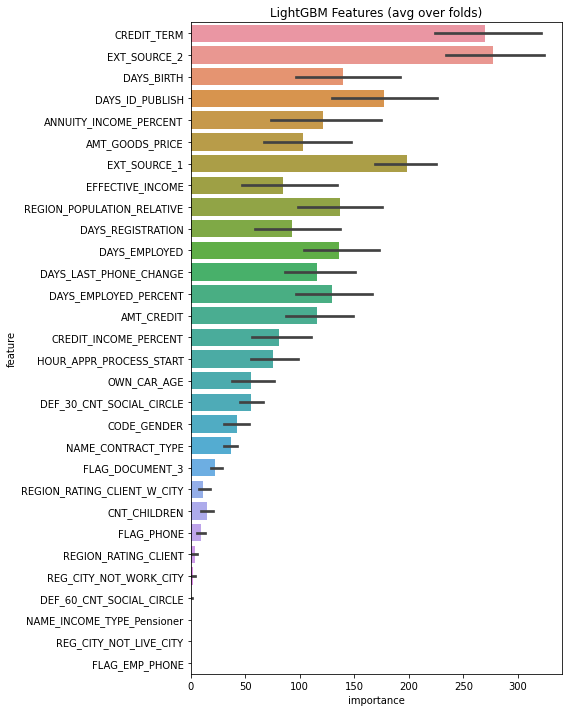

In [30]:
display_importances(feat_importance_2)

## Conclusion